In [1]:
from pyspark.sql import SparkSession
import socket
import os

spark_master = os.environ.get('SPARK_MASTER') # "spark://spark-master:7077" 
driver_host = socket.gethostbyname(socket.gethostname()) # setting driver host is important in k8s mode, ortherwise excutors cannot find diver host

spark = SparkSession \
    .builder \
    .master(spark_master)\
    .appName("MLOps") \
    .config("spark.driver.host", driver_host) \
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.1') \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
        
ACCESS_KEY = os.environ.get('AWS_ACCESS_KEY_ID')
SECRET_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
MLFLOW_S3_ENDPOINT_URL = os.environ.get('MLFLOW_S3_ENDPOINT_URL')

hadoopConf = spark.sparkContext._jsc.hadoopConfiguration()
hadoopConf.set('fs.s3a.access.key', ACCESS_KEY)
hadoopConf.set('fs.s3a.secret.key', SECRET_KEY)
hadoopConf.set("fs.s3a.endpoint", MLFLOW_S3_ENDPOINT_URL)
hadoopConf.set('fs.s3.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
hadoopConf.set("fs.s3a.connection.ssl.enabled", "true")
hadoopConf.set("fs.s3a.path.style.access", 'true')



:: loading settings :: url = jar:file:/spark-3.3.0-bin-hadoop3/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-39e29642-e90e-42b1-88c0-60ab32afa3bb;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
downloading https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.1/hadoop-aws-3.3.1.jar ...
	[SUCCESSFUL ] org.apache.hadoop#hadoop-aws;3.3.1!hadoop-aws.jar (556ms)
downloading https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.11.901/aws-java-sdk-bundle-1.11.901.jar ...
	[SUCCESSFUL ] com.amazonaws#aws-java-sdk-bundle;1.11.901!aws-java-sdk-bundle.jar (58938ms)
downloading https://repo1.maven.org/maven2/org/wildfly/openssl/wildfly-openssl/1.0.7.Final/wildfly-openssl-1.0.7.Final.jar ...
	[SUCCESSFUL ] org.wildfly.o

22/11/02 19:08:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
file_path = "s3://mlops/sf-listings.csv"
raw_df = spark.read.csv(file_path ,header="true", inferSchema="true", multiLine="true", escape='"')

In [3]:
columns_to_keep = [
    "host_is_superhost",
    "cancellation_policy",
    "instant_bookable",
    "host_total_listings_count",
    "neighbourhood_cleansed",
    "latitude",
    "longitude",
    "property_type",
    "room_type",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "bed_type",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "price"
]

base_df = raw_df.select(*columns_to_keep)


from pyspark.sql.functions import col, translate

fixed_price_df = base_df.withColumn("price", translate(col("price"), "$,", "").cast("double"))
pos_prices_df = fixed_price_df.filter(col("price") > 0)
min_nights_df = pos_prices_df.filter(col("minimum_nights") <= 365)

from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

integer_columns = [x.name for x in min_nights_df.schema.fields if x.dataType == IntegerType()]
doubles_df = min_nights_df

for c in integer_columns:
    doubles_df = doubles_df.withColumn(c, col(c).cast("double"))

    
    
from pyspark.sql.functions import when

impute_cols = [
    "bedrooms",
    "bathrooms",
    "beds", 
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value"
]

for c in impute_cols:
    doubles_df = doubles_df.withColumn(c + "_na", when(col(c).isNull(), 1.0).otherwise(0.0))    

from pyspark.ml.feature import Imputer

imputer = Imputer(strategy="median", inputCols=impute_cols, outputCols=impute_cols)

imputer_model = imputer.fit(doubles_df)
imputed_df = imputer_model.transform(doubles_df)

In [4]:
train_df, test_df = imputed_df.randomSplit([.8, .2], seed=42)

In [5]:
import mlflow
import mlflow.spark
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import RFormula

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

mlflow.set_experiment('my_experiment')
#mlflow.pyspark.ml.autolog(log_models=False)

<Experiment: artifact_location='s3://mlflow/1', creation_time=1667339559488, experiment_id='1', last_update_time=1667339559488, lifecycle_stage='active', name='my_experiment', tags={}>

In [8]:

with mlflow.start_run(run_name="LR-Multi-Features") as run:
    #

    # Define pipeline
    

    categorical_cols = [field for (field, dataType) in train_df.dtypes if dataType == "string"]
    index_output_cols = [x + "Index" for x in categorical_cols]
    ohe_output_cols = [x + "OHE" for x in categorical_cols]
    string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")
    ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)
    
    numeric_cols = [field for (field, dataType) in train_df.dtypes if ((dataType == "double") & (field != "price"))]
    assembler_inputs = ohe_output_cols + numeric_cols
    vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
    
    lr = GeneralizedLinearRegression(labelCol="price", featuresCol="features")
    
    stages = [string_indexer, ohe_encoder, vec_assembler, lr]
    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(train_df)
    

    # Log parameters
#     mlflow.log_param("label", "price")
#     mlflow.log_param("features", "multiple")

#     # Log model
#     mlflow.spark.log_model(pipeline_model, "model", input_example=train_df.limit(5).toPandas()) 

    # Evaluate predictions
#     pred_df = pipeline_model.transform(test_df)
#     regression_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")
#     rmse = regression_evaluator.setMetricName("rmse").evaluate(pred_df)
#     r2 = regression_evaluator.setMetricName("r2").evaluate(pred_df)

    # Log both metrics
#     mlflow.log_metric("rmse", rmse)
#     mlflow.log_metric("r2", r2)

2022/11/02 16:43:00 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pyspark.ml. If you encounter errors during autologging, try upgrading / downgrading pyspark.ml to a supported version, or try upgrading MLflow.
2022/11/02 16:43:00 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler.inputCols`. Truncated value: `['host_is_superhostOHE', 'cancellation_policyOHE', 'instant_bookableOHE', 'neighbourhood_cleansedOHE', 'property_typeOHE', 'room_typeOHE', 'bed_typeOHE', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'bedrooms_na', 'bathrooms_na', 'beds_na', 'review_scores...`
2022/11/02 16:43:03 WARNING mlflow.pyspark.ml: Failed to infer model signature: could not sample data to infer model signature: Cannot

In [35]:
mlflow.pyspark.ml.autolog(log_models=False)

with mlflow.start_run(run_name="RF-All-Features") as run:
    categorical_cols = [field for (field, dataType) in train_df.dtypes if dataType == "string"]
    index_output_cols = [x + "_Index" for x in categorical_cols]

    string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")

    numeric_cols = [field for (field, dataType) in train_df.dtypes if ((dataType == "double") & (field != "price"))]
    assembler_inputs = index_output_cols + numeric_cols
    vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

    rf = RandomForestRegressor(labelCol="price", maxBins=40)
    
    param_grid = (ParamGridBuilder()
                  .addGrid(rf.maxDepth, [2, 5])
                  .addGrid(rf.numTrees, [5, 10])
                  .build())

    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")

    # Pipeline in CV: take much longer time if there are estimators in pipeline, which have to be refitted in every validation
    
#     stages = [string_indexer, vec_assembler, rf]
#     pipeline = Pipeline(stages=stages)
#     cv = CrossValidator(estimator=pipeline, evaluator=evaluator, estimatorParamMaps=param_grid, 
#                         numFolds=10, parallelism=4, seed=42)
#     cv_model = cv.setParallelism(4).fit(train_df)


    # CV in pipeline: potential risk of data leakage
    cv = CrossValidator(estimator=rf, evaluator=evaluator, estimatorParamMaps=param_grid, 
                    numFolds=3, parallelism=4, seed=42)
    stages_with_cv = [string_indexer, vec_assembler, cv]
    pipeline = Pipeline(stages=stages_with_cv)
    pipeline_model = pipeline.fit(train_df)

#     # Log parameter
#     mlflow.log_param("label", "price")
#     mlflow.log_param("features", "all_features")

    # Create predictions and metrics
    
    best_model = pipeline_model.stages[-1].bestModel
    best_pipeline_model = Pipeline(stages=[string_indexer, vec_assembler, best_model]).fit(train_df)
    pred_df = best_pipeline_model.transform(test_df)
    rmse = evaluator.setMetricName("rmse").evaluate(pred_df)
    r2 = evaluator.setMetricName("r2").evaluate(pred_df)

    # Log both metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
      
    mlflow.spark.log_model(best_pipeline_model, "model", input_example=train_df.limit(5).toPandas())
    
    
    import pandas as pd
    import matplotlib.pyplot as plt
    
    features_df = pd.DataFrame(list(zip(vec_assembler.getInputCols(), best_model.featureImportances)), columns=["feature", "importance"])
    features_df = features_df.sort_values(by = 'importance',ascending=False).head(10)
    fig, ax = plt.subplots()
    features_df.plot(kind='barh', x='feature', y='importance', ax=ax)
    mlflow.log_figure(fig, "feature_importance.png")



2022/11/02 19:45:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pyspark.ml. If you encounter errors during autologging, try upgrading / downgrading pyspark.ml to a supported version, or try upgrading MLflow.
2022/11/02 19:45:41 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler.inputCols`. Truncated value: `['host_is_superhost_Index', 'cancellation_policy_Index', 'instant_bookable_Index', 'neighbourhood_cleansed_Index', 'property_type_Index', 'room_type_Index', 'bed_type_Index', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'bedrooms_na', 'bathrooms_na', 'bed...`
2022/11/02 19:45:47 WARNING mlflow.pyspark.ml: Failed to infer model signature: could not sample data to infer model signature: Cannot

22/11/02 19:45:47 ERROR TaskSetManager: Task 0 in stage 2774.0 failed 4 times; aborting job
22/11/02 19:45:47 ERROR SparkHadoopWriter: Aborting job job_202211021945474999836091711706331_9027.
org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2774.0 failed 4 times, most recent failure: Lost task 0.3 in stage 2774.0 (TID 2765) (192.168.96.6 executor 3): java.io.IOException: Cannot run program "python3": error=2, No such file or directory
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1128)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1071)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:216)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:134)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.pyt

2022/11/02 19:45:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during pyspark.ml autologging: An error occurred while calling o61762.saveAsTextFile.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:106)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDD

2022/11/02 19:45:48 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler.inputCols`. Truncated value: `['host_is_superhost_Index', 'cancellation_policy_Index', 'instant_bookable_Index', 'neighbourhood_cleansed_Index', 'property_type_Index', 'room_type_Index', 'bed_type_Index', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'bedrooms_na', 'bathrooms_na', 'bed...`


22/11/02 19:45:48 ERROR TaskSetManager: Task 0 in stage 2775.0 failed 4 times; aborting job
22/11/02 19:45:48 ERROR SparkHadoopWriter: Aborting job job_202211021945486845244776678952301_9031.
org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2775.0 failed 4 times, most recent failure: Lost task 0.3 in stage 2775.0 (TID 2769) (192.168.96.9 executor 0): java.io.IOException: Cannot run program "python3": error=2, No such file or directory
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1128)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1071)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:216)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:134)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.pyt

2022/11/02 19:45:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during pyspark.ml autologging: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'stages', 'old_value': "['StringIndexer', 'VectorAssembler', 'CrossValidator']", 'new_value': "['StringIndexer', 'VectorAssembler', 'RandomForestRegressionModel']"}]' for run ID='41b46af495fe4e57b9e99dbcc3f86af5'.


22/11/02 19:45:49 ERROR Instrumentation: java.io.IOException: Path s3://mlflow/1/41b46af495fe4e57b9e99dbcc3f86af5/artifacts/model/sparkml already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelW

KeyboardInterrupt: 

     |████████████████████████████████| 11.6 MB 3.3 MB/s eta 0:00:01    |█████████████████████           | 7.6 MB 2.4 MB/s eta 0:00:02
     |████████████████████████████████| 288 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 280 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 3.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


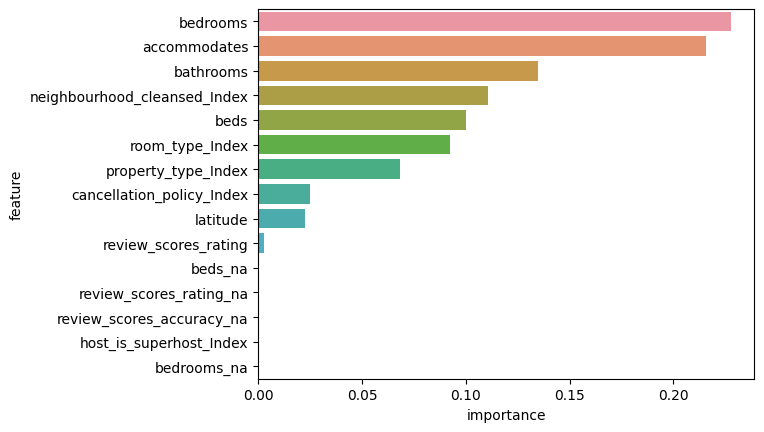

In [7]:
%pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns

features_df = features_df.sort_values(by = 'importance',ascending=False).head(15)
plot = sns.barplot(x=features_df['importance'], y=features_df['feature'])

  0%|          | 0/4 [00:00<?, ?trial/s, best loss=?]

2022/11/02 20:43:02 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler.inputCols`. Truncated value: `['host_is_superhostIndex', 'cancellation_policyIndex', 'instant_bookableIndex', 'neighbourhood_cleansedIndex', 'property_typeIndex', 'room_typeIndex', 'bed_typeIndex', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'bedrooms_na', 'bathrooms_na', 'beds_na', ...`

2022/11/02 20:43:04 WARNING mlflow.pyspark.ml: Failed to infer model signature: could not sample data to infer model signature: Cannot resolve column name "host_is_superhost" among (cancellation_policy, instant_bookable, host_total_listings_count, neighbourhood_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, review_

 25%|██▌       | 1/4 [00:10<00:30, 10.24s/trial, best loss: 212.16709675664123]

2022/11/02 20:43:12 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler.inputCols`. Truncated value: `['host_is_superhostIndex', 'cancellation_policyIndex', 'instant_bookableIndex', 'neighbourhood_cleansedIndex', 'property_typeIndex', 'room_typeIndex', 'bed_typeIndex', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'bedrooms_na', 'bathrooms_na', 'beds_na', ...`

2022/11/02 20:43:13 WARNING mlflow.pyspark.ml: Failed to infer model signature: could not sample data to infer model signature: Cannot resolve column name "host_is_superhost" among (cancellation_policy, instant_bookable, host_total_listings_count, neighbourhood_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, review_

 50%|█████     | 2/4 [00:20<00:19,  9.99s/trial, best loss: 212.16709675664123]

2022/11/02 20:43:22 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler.inputCols`. Truncated value: `['host_is_superhostIndex', 'cancellation_policyIndex', 'instant_bookableIndex', 'neighbourhood_cleansedIndex', 'property_typeIndex', 'room_typeIndex', 'bed_typeIndex', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'bedrooms_na', 'bathrooms_na', 'beds_na', ...`

2022/11/02 20:43:23 WARNING mlflow.pyspark.ml: Failed to infer model signature: could not sample data to infer model signature: Cannot resolve column name "host_is_superhost" among (cancellation_policy, instant_bookable, host_total_listings_count, neighbourhood_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, review_

 75%|███████▌  | 3/4 [00:30<00:10, 10.01s/trial, best loss: 210.83653636610592]

2022/11/02 20:43:32 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler.inputCols`. Truncated value: `['host_is_superhostIndex', 'cancellation_policyIndex', 'instant_bookableIndex', 'neighbourhood_cleansedIndex', 'property_typeIndex', 'room_typeIndex', 'bed_typeIndex', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'bedrooms_na', 'bathrooms_na', 'beds_na', ...`

2022/11/02 20:43:33 WARNING mlflow.pyspark.ml: Failed to infer model signature: could not sample data to infer model signature: Cannot resolve column name "host_is_superhost" among (cancellation_policy, instant_bookable, host_total_listings_count, neighbourhood_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, review_

100%|██████████| 4/4 [00:40<00:00, 10.10s/trial, best loss: 208.9789295610556] 

2022/11/02 20:43:42 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler.inputCols`. Truncated value: `['host_is_superhostIndex', 'cancellation_policyIndex', 'instant_bookableIndex', 'neighbourhood_cleansedIndex', 'property_typeIndex', 'room_typeIndex', 'bed_typeIndex', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'bedrooms_na', 'bathrooms_na', 'beds_na', ...`


2022/11/02 20:43:44 WARNING mlflow.pyspark.ml: Failed to infer model signature: could not sample data to infer model signature: Cannot resolve column name "host_is_superhost" among (cancellation_policy, instant_bookable, host_total_listings_count, neighbourhood_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, price, bedrooms_na, bathrooms_na, beds_na, review_scores_rating_na, review_scores_accuracy_na, review_scores_cleanliness_na, review_scores_checkin_na, review_scores_communication_na, review_scores_location_na, review_scores_value_na)
2022/11/02 20:44:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpusnb9er8, flavor: spark), fall back to return ['pyspark==3.3.1']. Set logging level to 

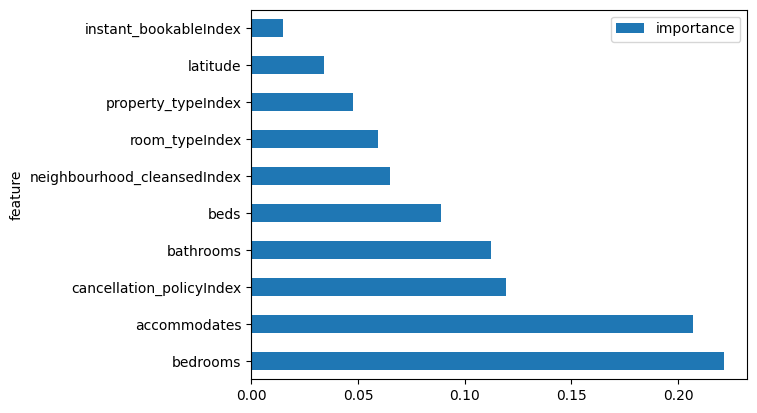

In [37]:
from hyperopt import hp


train_df, val_df, test_df = imputed_df.randomSplit([.6, .2, .2], seed=42)


categorical_cols = [field for (field, dataType) in train_df.dtypes if dataType == "string"]
index_output_cols = [x + "Index" for x in categorical_cols]

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")

numeric_cols = [field for (field, dataType) in train_df.dtypes if ((dataType == "double") & (field != "price"))]
assembler_inputs = index_output_cols + numeric_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
rf = RandomForestRegressor(labelCol="price", maxBins=40)
pipeline = Pipeline(stages=[string_indexer, vec_assembler, rf])
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")


def objective_function(params):    
    # set the hyperparameters that we want to tune
    max_depth = params["max_depth"]
    num_trees = params["num_trees"]
    with mlflow.start_run():
        estimator = pipeline.copy({rf.maxDepth: max_depth, rf.numTrees: num_trees})
        model = estimator.fit(train_df)

        preds = model.transform(val_df)
        rmse = evaluator.evaluate(preds)
        mlflow.log_metric("rmse", rmse)
    return rmse


search_space = {
    "max_depth": hp.quniform("max_depth", 2, 5, 1),
    "num_trees": hp.quniform("num_trees", 10, 100, 1)
}



from hyperopt import fmin, tpe, Trials
import numpy as np
import mlflow
import mlflow.spark

num_evals = 4
trials = Trials()
best_hyperparam = fmin(fn=objective_function, 
                       space=search_space,
                       algo=tpe.suggest, 
                       max_evals=num_evals,
                       trials=trials,
                       rstate=np.random.default_rng(42))


with mlflow.start_run(run_name="RF-Hyperopt") as run:
    best_max_depth = best_hyperparam["max_depth"]
    best_num_trees = best_hyperparam["num_trees"]
    estimator = pipeline.copy({rf.maxDepth: best_max_depth, rf.numTrees: best_num_trees})
    combined_df = train_df.union(val_df) # Combine train & validation together

    pipeline_model = estimator.fit(combined_df)
    pred_df = pipeline_model.transform(test_df)
    rmse = evaluator.setMetricName("rmse").evaluate(pred_df)
    r2 = evaluator.setMetricName("r2").evaluate(pred_df)

    # Log param and metrics for the final model
    # mlflow.log_param("maxDepth", best_max_depth)
    # mlflow.log_param("numTrees", best_num_trees)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    #mlflow.spark.log_model(pipeline_model, "model", input_example=combined_df.limit(5).toPandas())

    best_model = pipeline_model.stages[-1]
    features_df = pd.DataFrame(list(zip(vec_assembler.getInputCols(), best_model.featureImportances)), columns=["feature", "importance"])
    features_df = features_df.sort_values(by = 'importance',ascending=False).head(10)
    fig, ax = plt.subplots()
    features_df.plot(kind='barh', x='feature', y='importance', ax=ax)
    mlflow.log_figure(fig, "feature_importance.png")

In [13]:
from mlflow.tracking import MlflowClient
client = MlflowClient()
display(client.search_experiments())

experiment_id = run.info.experiment_id
runs_df = mlflow.search_runs(experiment_id)

display(runs_df)

[<Experiment: artifact_location='s3://mlflow/1', creation_time=1667339559488, experiment_id='1', last_update_time=1667339559488, lifecycle_stage='active', name='my_experiment', tags={}>]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_test_df,metrics.rmse,metrics.rmse_unknown_dataset,metrics.r2_test_df,...,params.LinearRegression.solver,params.LinearRegression.aggregationDepth,params.LinearRegression.elasticNetParam,tags.mlflow.log-model.history,tags.mlflow.source.name,tags.mlflow.source.type,tags.estimator_name,tags.mlflow.runName,tags.estimator_class,tags.mlflow.user
0,88079509a46b4a99bfff323b188f906d,1,FINISHED,s3://mlflow/1/88079509a46b4a99bfff323b188f906d...,2022-11-02 17:19:03.444000+00:00,2022-11-02 17:21:14.154000+00:00,215.142643,NaN,NaN,NaN,...,None,None,None,"[{""run_id"": ""88079509a46b4a99bfff323b188f906d""...",/usr/local/lib/python3.9/site-packages/ipykern...,LOCAL,Pipeline,RF-Hyperopt,pyspark.ml.pipeline.Pipeline,root
1,5ed9d19d287d47cd960af057e6bb5704,1,FINISHED,s3://mlflow/1/5ed9d19d287d47cd960af057e6bb5704...,2022-11-02 17:16:55.926000+00:00,2022-11-02 17:19:03.340000+00:00,NaN,214.435470,214.435470,NaN,...,None,None,None,"[{""run_id"": ""5ed9d19d287d47cd960af057e6bb5704""...",/usr/local/lib/python3.9/site-packages/ipykern...,LOCAL,Pipeline,luminous-pug-920,pyspark.ml.pipeline.Pipeline,root
2,69338e6596934c248d0c8fdcbefa5618,1,FINISHED,s3://mlflow/1/69338e6596934c248d0c8fdcbefa5618...,2022-11-02 17:15:05.940000+00:00,2022-11-02 17:16:55.858000+00:00,NaN,214.272605,214.272605,NaN,...,None,None,None,"[{""run_id"": ""69338e6596934c248d0c8fdcbefa5618""...",/usr/local/lib/python3.9/site-packages/ipykern...,LOCAL,Pipeline,sassy-lark-665,pyspark.ml.pipeline.Pipeline,root
3,74643e52a7dd46c5a7cb28054e61993c,1,FINISHED,s3://mlflow/1/74643e52a7dd46c5a7cb28054e61993c...,2022-11-02 17:14:06.339000+00:00,2022-11-02 17:15:05.681000+00:00,NaN,216.002256,216.002256,NaN,...,None,None,None,"[{""run_id"": ""74643e52a7dd46c5a7cb28054e61993c""...",/usr/local/lib/python3.9/site-packages/ipykern...,LOCAL,Pipeline,powerful-panda-214,pyspark.ml.pipeline.Pipeline,root
4,ce92cc131d854c7e9a5d1d79c199650b,1,FINISHED,s3://mlflow/1/ce92cc131d854c7e9a5d1d79c199650b...,2022-11-02 17:12:55.292000+00:00,2022-11-02 17:14:06.198000+00:00,NaN,216.496408,216.496408,NaN,...,None,None,None,"[{""run_id"": ""ce92cc131d854c7e9a5d1d79c199650b""...",/usr/local/lib/python3.9/site-packages/ipykern...,LOCAL,Pipeline,useful-steed-300,pyspark.ml.pipeline.Pipeline,root
5,1d634b25155d470581689566530c67af,1,FINISHED,s3://mlflow/1/1d634b25155d470581689566530c67af...,2022-11-02 17:11:47.961000+00:00,2022-11-02 17:11:49.370000+00:00,215.142643,NaN,NaN,NaN,...,None,None,None,None,/usr/local/lib/python3.9/site-packages/ipykern...,LOCAL,Pipeline,RF-Hyperopt,pyspark.ml.pipeline.Pipeline,root
6,e4522dcf268f40da9c3f2a35f20fa8f9,1,FINISHED,s3://mlflow/1/e4522dcf268f40da9c3f2a35f20fa8f9...,2022-11-02 17:11:46.484000+00:00,2022-11-02 17:11:47.922000+00:00,NaN,214.435470,214.435470,NaN,...,None,None,None,None,/usr/local/lib/python3.9/site-packages/ipykern...,LOCAL,Pipeline,unruly-rat-905,pyspark.ml.pipeline.Pipeline,root
7,96b76b6c8614440c9d70c7f8fd64f4f8,1,FINISHED,s3://mlflow/1/96b76b6c8614440c9d70c7f8fd64f4f8...,2022-11-02 17:11:45.284000+00:00,2022-11-02 17:11:46.446000+00:00,NaN,214.272605,214.272605,NaN,...,None,None,None,None,/usr/local/lib/python3.9/site-packages/ipykern...,LOCAL,Pipeline,lyrical-sloth-545,pyspark.ml.pipeline.Pipeline,root
8,a0f480e3ed5a4f5e9320fe4da195da0e,1,FINISHED,s3://mlflow/1/a0f480e3ed5a4f5e9320fe4da195da0e...,2022-11-02 17:11:43.713000+00:00,2022-11-02 17:11:45.240000+00:00,NaN,216.002256,216.002256,NaN,...,None,None,None,None,/usr/local/lib/python3.9/site-packages/ipykern...,LOCAL,Pipeline,sneaky-croc-961,pyspark.ml.pipeline.Pipeline,root
9,841e83f7923240c7897bcf10ac92b02a,1,FINISHED,s3://mlflow/1/841e83f7923240c7897bcf10ac92b02a...,2022-11-02 17:11:41.098000+00:00,2022-11-02 17:11:43.666000+00:00,NaN,216.496408,216.496408,NaN,...,None,None,None,None,/usr/local/lib/python3.9/site-packages/ipykern...,LOCAL,Pipeline,learned-penguin-372,pyspark.ml.pipeline.Pipeline,root


In [10]:
model_name = f"OPS_mllib_lr"
model_uri = f"runs:/{run.info.run_id}/model"

model_details = mlflow.register_model(model_uri=model_uri, name=model_name)


from mlflow.tracking.client import MlflowClient

client = MlflowClient()

client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="Staging"
)

Successfully registered model 'OPS_mllib_lr'.
2022/11/01 22:02:49 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: OPS_mllib_lr, version 1
Created version '1' of model 'OPS_mllib_lr'.


<ModelVersion: creation_timestamp=1667340169489, current_stage='Staging', description='', last_updated_timestamp=1667340169527, name='OPS_mllib_lr', run_id='74918b5aa0cc424091b68b9c2fea57ce', run_link='', source='s3://mlflow/1/74918b5aa0cc424091b68b9c2fea57ce/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [14]:
from pysparkling.ml import H2OAutoML
from pysparkling import *
hc = H2OContext.getOrCreate()


Connecting to H2O server at http://172.21.0.9:54321 ... successful.


H2O_cluster_uptime:,12 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,sparkling-water-root_app-20221102084732-0002
H2O_cluster_total_nodes:,4
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.38.0.1-1-3.3
 * H2O name: root
 * cluster size: 4
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.21.0.5,54321)
  (1,172.21.0.6,54321)
  (2,172.21.0.7,54321)
  (3,172.21.0.8,54321)
  ------------------------

  Open H2O Flow in browser: http://172.21.0.9:54321 (CMD + click in Mac OSX)

    


In [11]:
automl = H2OAutoML(labelCol="price")

automl.setExcludeAlgos(["GLM","DeepLearning"])
automl.setMaxModels(10)

automl.setSortMetric("rmse")
model = automl.fit(train_df)

|██████████████████████████████████████████████████| 100%


12 models trained. For more details use the getLeaderboard() method on the AutoML object.
Returning leader model and printing info about it below.
Model Details
H2OStackedEnsemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20221101_220417_5d5b54b3250e

Model summary

Training metrics
RMSLE: 0.3435283962755265
Nobs: 5780.0
RMSE: 221.1374775216042
ResidualDeviance: 2.826523113154921E8
NullDeviance: 6.13603612626122E8
MAE: 61.557052324486484
MeanResidualDeviance: 48901.78396461801
ScoringTime: 1.667340377619E12
MSE: 48901.78396461801
R2: 0.5393568331421882
NullDegreesOfFreedom: 5779.0
AIC: 78824.87916952313
ResidualDegreesOfFreedom: 5775.0

Cross validation metrics
RMSLE: 0.44482103487838104
Nobs: 5780.0
RMSE: 288.32437785112336
ResidualDeviance: 4.8049687286951196E8
NullDeviance: 6.13678515863046E8
MAE: 79.7050802213163
MeanResidualDeviance: 83130.94686323736
ScoringTime: 1.667340377351E12
MSE: 83130.94686323736
R2: 0.21692626480300092
NullDegreesOfFreedom: 5779.0
AIC: 81891.7654338

In [12]:
leaderboard = automl.getLeaderboard("ALL")


In [13]:
leaderboard.show()

+---+--------------------+------------------+-----------------+-----------------+-------------------+----------------------+----------------+-----------------------+---------------+
|   |            model_id|              rmse|              mse|              mae|              rmsle|mean_residual_deviance|training_time_ms|predict_time_per_row_ms|           algo|
+---+--------------------+------------------+-----------------+-----------------+-------------------+----------------------+----------------+-----------------------+---------------+
|  0|StackedEnsemble_A...|288.32437785112336|83130.94686323736| 79.7050802213163|0.44482103487838104|     83130.94686323736|            2033|                   null|StackedEnsemble|
|  1|StackedEnsemble_B...|  288.333581023451|  83136.253945807|80.45069309095949|                NaN|       83136.253945807|            3083|                   null|StackedEnsemble|
|  2|GBM_grid_1_AutoML...| 289.1316493957896|83597.11068232982|82.19559504243428|         

In [15]:
#from sparkdl.xgboost import XgboostRegressor
#from xgboost.spark import SparkXGBRegressor
from pysparkling.ml import H2OXGBoostRegressor
from pyspark.sql.functions import exp, col, log


train_df, test_df = imputed_df.withColumn("label", col("price")).randomSplit([.8, .2], seed=42)


with mlflow.start_run(run_name="Xgboost") as run:
    # Create pipeline
    categorical_cols = [field for (field, dataType) in train_df.dtypes if dataType == "string"]
    index_output_cols = [x + "Index" for x in categorical_cols]
    string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")    
    numeric_cols = [field for (field, dataType) in train_df.dtypes if ((dataType == "double") & (field != "price"))]
    assembler_inputs = index_output_cols + numeric_cols
    vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
    
    #params = {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 4, "random_state": 42, "missing": 0 ,'eval_metric':'rmse'}
    xgboost = H2OXGBoostRegressor( labelCol = "price" )
    stages = [string_indexer, vec_assembler, xgboost]

    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(train_df)

    # Log pipeline
    mlflow.spark.log_model(pipeline_model, "model", input_example=train_df.limit(5).toPandas())

    # Log parameter
    mlflow.log_param("label", "price")
    mlflow.log_param("features", "all_features")

    # Create predictions and metrics
    pred_df = pipeline_model.transform(test_df)
    regression_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
    rmse = regression_evaluator.setMetricName("rmse").evaluate(pred_df)
    r2 = regression_evaluator.setMetricName("r2").evaluate(pred_df)

    # Log both metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    
    xgb_model = pipeline_model.stages[-1]

    import pandas as pd

    features_df = pd.DataFrame(list(zip(vec_assembler.getInputCols(), xgb_model.get_feature_importances(importance_type='weight').values())), columns=["feature", "importance"])
    display(features_df.sort_values('importance'))

Py4JJavaError: An error occurred while calling o2267.fit.
: ai.h2o.sparkling.backend.exceptions.RestApiCommunicationException: H2O node http://172.21.0.5:54321 responded with
Status code: 404 : Not Found
Server error: {"__meta":{"schema_version":3,"schema_name":"H2OErrorV3","schema_type":"H2OError"},"timestamp":1667379149848,"error_url":"POST /3/ModelBuilders/xgboost","msg":"\n\nERROR MESSAGE:\n\nPOST /3/ModelBuilders/xgboost not found\n\n","dev_msg":"\n\nERROR MESSAGE:\n\nPOST /3/ModelBuilders/xgboost not found\n\n","http_status":404,"values":{},"exception_type":"water.exceptions.H2ONotFoundArgumentException","exception_msg":"\n\nERROR MESSAGE:\n\nPOST /3/ModelBuilders/xgboost not found\n\n","stacktrace":["water.exceptions.H2ONotFoundArgumentException: POST /3/ModelBuilders/xgboost not found","    water.api.RequestServer.response404(RequestServer.java:745)","    water.api.RequestServer.serve(RequestServer.java:469)","    water.api.RequestServer.doGeneric(RequestServer.java:303)","    water.api.RequestServer.doPost(RequestServer.java:227)","    javax.servlet.http.HttpServlet.service(HttpServlet.java:523)","    javax.servlet.http.HttpServlet.service(HttpServlet.java:590)","    ai.h2o.org.eclipse.jetty.servlet.ServletHolder.handle(ServletHolder.java:865)","    ai.h2o.org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:535)","    ai.h2o.org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:255)","    ai.h2o.org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1317)","    ai.h2o.org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:203)","    ai.h2o.org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:473)","    ai.h2o.org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:201)","    ai.h2o.org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1219)","    ai.h2o.org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:144)","    ai.h2o.org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:126)","    ai.h2o.org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)","    water.webserver.jetty9.Jetty9ServerAdapter$LoginHandler.handle(Jetty9ServerAdapter.java:130)","    ai.h2o.org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:126)","    ai.h2o.org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)","    ai.h2o.org.eclipse.jetty.server.Server.handle(Server.java:531)","    ai.h2o.org.eclipse.jetty.server.HttpChannel.handle(HttpChannel.java:352)","    ai.h2o.org.eclipse.jetty.server.HttpConnection.onFillable(HttpConnection.java:260)","    ai.h2o.org.eclipse.jetty.io.AbstractConnection$ReadCallback.succeeded(AbstractConnection.java:281)","    ai.h2o.org.eclipse.jetty.io.FillInterest.fillable(FillInterest.java:102)","    ai.h2o.org.eclipse.jetty.io.ChannelEndPoint$2.run(ChannelEndPoint.java:118)","    ai.h2o.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.runTask(EatWhatYouKill.java:333)","    ai.h2o.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:310)","    ai.h2o.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:168)","    ai.h2o.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:126)","    ai.h2o.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:366)","    ai.h2o.org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:762)","    ai.h2o.org.eclipse.jetty.util.thread.QueuedThreadPool$2.run(QueuedThreadPool.java:680)","    java.base/java.lang.Thread.run(Thread.java:829)"]}
	at ai.h2o.sparkling.backend.utils.RestCommunication.checkResponseCode(RestCommunication.scala:414)
	at ai.h2o.sparkling.backend.utils.RestCommunication.checkResponseCode$(RestCommunication.scala:394)
	at ai.h2o.sparkling.ml.algos.H2OEstimator.checkResponseCode(H2OEstimator.scala:16)
	at ai.h2o.sparkling.backend.utils.RestCommunication.readURLContent(RestCommunication.scala:386)
	at ai.h2o.sparkling.backend.utils.RestCommunication.readURLContent$(RestCommunication.scala:370)
	at ai.h2o.sparkling.ml.algos.H2OEstimator.readURLContent(H2OEstimator.scala:16)
	at ai.h2o.sparkling.backend.utils.RestCommunication.request(RestCommunication.scala:182)
	at ai.h2o.sparkling.backend.utils.RestCommunication.request$(RestCommunication.scala:172)
	at ai.h2o.sparkling.ml.algos.H2OEstimator.request(H2OEstimator.scala:16)
	at ai.h2o.sparkling.backend.utils.RestCommunication.update(RestCommunication.scala:88)
	at ai.h2o.sparkling.backend.utils.RestCommunication.update$(RestCommunication.scala:81)
	at ai.h2o.sparkling.ml.algos.H2OEstimator.update(H2OEstimator.scala:16)
	at ai.h2o.sparkling.ml.utils.EstimatorCommonUtils.trainAndGetDestinationKey(EstimatorCommonUtils.scala:36)
	at ai.h2o.sparkling.ml.utils.EstimatorCommonUtils.trainAndGetDestinationKey$(EstimatorCommonUtils.scala:30)
	at ai.h2o.sparkling.ml.algos.H2OEstimator.trainAndGetDestinationKey(H2OEstimator.scala:16)
	at ai.h2o.sparkling.ml.algos.H2OEstimator.trainH2OModel(H2OEstimator.scala:51)
	at ai.h2o.sparkling.ml.algos.H2OEstimator.fit(H2OEstimator.scala:36)
	at ai.h2o.sparkling.ml.algos.H2OAlgorithm.fit(H2OAlgorithm.scala:41)
	at ai.h2o.sparkling.ml.algos.H2OSupervisedAlgorithm.fit(H2OSupervisedAlgorithm.scala:57)
	at ai.h2o.sparkling.ml.algos.H2OTreeBasedSupervisedAlgorithm.fit(H2OTreeBasedSupervisedAlgorithm.scala:30)
	at ai.h2o.sparkling.ml.algos.H2OXGBoost.fit(H2OXGBoost.scala:35)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
